In [1]:
import os

import pickle

import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [2]:
alert_data = pd.read_csv(
    "dataset/alert.csv", 
    index_col=0, 
    encoding="utf-8"
)
alert_data.shape

(489850, 15)

In [3]:
netflow_fields = pd.read_csv("dataset/netflow/netflow-feats.csv").columns

flows_list = os.listdir("dataset/netflow/flow/")
np.random.shuffle(flows_list)

sample_size = 1000
sample_list = flows_list[:sample_size]
test_list = flows_list[sample_size:]

In [4]:
ident_features = [
    'src_ip',
    'dst_ip',
    'src_port', 
    'dst_port'
]
port_features = [
    'src_port', 
    'dst_port'
]
ip_features = [
    'ip_proto_x', 
    'ip_proto_pkt_cnt',
    'ip_proto_bytes_cnt',
]
udp_features = [
    'udp_proto_pkt_cnt',
    'udp_proto_bytes_cnt', 
]
tcp_features = [
    'tcp_proto_pkt_cnt',
    'tcp_proto_bytes_cnt', 
    'tcp_proto_syn_cnt', 
    'tcp_proto_fin_cnt',
    'tcp_proto_ack_cnt', 
    'tcp_proto_psh_cnt',
    'tcp_proto_rst_cnt',
    'tcp_proto_synack_cnt',
]
icmp_features = [
    'icmp_proto_pkt_cnt',
    'icmp_proto_bytes_cnt',
    'icmp_proto_echo_request_cnt',
    'icmp_proto_echo_reply_cnt'
]
http_features = [
    'http_proto_get_pkt_cnt', 
    'http_proto_post_pkt_cnt',
    'http_proto_http_pkt_cnt',
    'http_proto_200_pkt_cnt',
    'http_proto_301_pkt_cnt', 
    'http_proto_302_pkt_cnt',
    'http_proto_304_pkt_cnt', 
    'http_proto_400_pkt_cnt',
    'http_proto_401_pkt_cnt', 
    'http_proto_403_pkt_cnt',
    'http_proto_404_pkt_cnt', 
    'http_proto_429_pkt_cnt',
    'http_proto_500_pkt_cnt', 
    'http_proto_503_pkt_cnt',
    'http_proto_511_pkt_cnt'
]
dns_features = [
    'dns_query_cnt', 
    'dns_response_cnt'
]
pkt_features = (
      port_features
    + ip_features 
    + tcp_features 
    + udp_features
    + icmp_features 
    + http_features 
    + dns_features
)

In [5]:
feats = (
      port_features
    + ip_features 
    + tcp_features 
    + udp_features
    + icmp_features 
    + dns_features
)
timestamp_feats = [
    'first_alert_time_sec',
    'last_alert_time_sec',
    'first_pkt_time_sec',
    'last_pkt_time_sec'
]

In [6]:
disbalance = 10

In [7]:
balanced_batches = []
batch_size = 50
print("start...", end='')
for batch_count in range(len(sample_list) // batch_size):
    print(f"\rbatch n. {batch_count} initialization...", end='')
    batch = pd.concat(
        [
            pd.concat(
                [
                    pd.read_csv(
                        f"dataset/netflow/flow/{filename}", 
                        names=netflow_fields,  
                        encoding="cp1251"
                    ) for filename in sample_list[s:s+5]
                ],
                ignore_index=True
            ).merge(
                alert_data, 
                how='left', 
                on=ident_features,
                indicator=True
            ) [feats + timestamp_feats + ['_merge']] 
            for s in range(batch_size * (batch_count)   ,
                           batch_size * (batch_count + 1), 5)
        ],
        ignore_index=True
    )
    batch['is_alert'] = batch['_merge'].replace(
        {
            'both': 1, 'left_only': 0, 'right_only': 0
        },
    )
    batch = batch[
        (
            (
                batch.is_alert == 1
            ) & (
                batch.first_alert_time_sec >= batch.first_pkt_time_sec
            ) & (
                batch.first_alert_time_sec <= batch.last_pkt_time_sec
            ) & (
                batch.last_alert_time_sec <= batch.last_pkt_time_sec
            )
        ) | (
            batch.is_alert == 0
        )
    ][feats + ['is_alert']]
    
    alert_index = batch[batch.is_alert == 1].index

    balanced_batch_index = np.concatenate(
        [
            np.random.choice(
                batch[batch.is_alert == 0].index, 
                size=alert_index.shape[0] * disbalance,
                replace=False
            ), 
            alert_index
        ], 
        axis=0
    )
    balanced_batches.append(batch.loc[balanced_batch_index])

batch n. 19 initialization...

In [8]:
X = pd.concat(
    balanced_batches,
    sort=False,
    ignore_index=True
).drop_duplicates()

y = X['is_alert']
X = X[feats]
X.shape

(2526823, 21)

In [9]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=None,
    learning_rate=0.1,
    subsample=0.8,
    n_jobs=-1,
    #verbosity=2
)

In [10]:
xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [11]:
balanced_batches = []
batch_size = 50
for batch_count in range(len(test_list) // batch_size):
    batch = pd.concat(
        [
            pd.concat(
                [
                    pd.read_csv(
                        f"dataset/netflow/flow/{filename}", 
                        names=netflow_fields,  
                        encoding="cp1251"
                    ) for filename in test_list[s:s+5]
                ],
                ignore_index=True
            ).merge(
                alert_data, 
                how='left', 
                on=ident_features,
                indicator=True
            ) [feats + timestamp_feats + ['_merge']] 
            for s in range(batch_size * (batch_count)   ,
                           batch_size * (batch_count + 1), 5)
        ],
        ignore_index=True
    )
    batch['is_alert'] = batch['_merge'].replace(
        {
            'both': 1, 'left_only': 0, 'right_only': 0
        },
    )
    batch = batch[
        (
            (
                batch.is_alert == 1
            ) & (
                batch.first_alert_time_sec >= batch.first_pkt_time_sec
            ) & (
                batch.first_alert_time_sec <= batch.last_pkt_time_sec
            ) & (
                batch.last_alert_time_sec <= batch.last_pkt_time_sec
            )
        ) | (
            batch.is_alert == 0
        )
    ][feats + ['is_alert']]
    
    alert_index = batch[batch.is_alert == 1].index
    balanced_batch_index = np.concatenate(
        [
            np.random.choice(
                batch[batch.is_alert == 0].index, 
                size=alert_index.shape[0] * disbalance,
                replace=False
            ), 
            alert_index
        ], 
        axis=0
    )
    balanced_batches.append(batch.loc[balanced_batch_index])

In [12]:
X_test = pd.concat(
    balanced_batches,
    sort=False,
    ignore_index=True
)
y_test = X_test.is_alert
X_test = X_test[feats]

In [13]:
y_pred = xgb.predict(X_test)

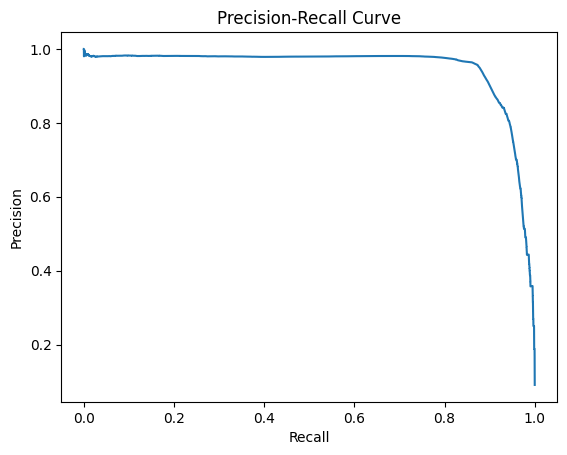

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_true = y_test
y_scores = xgb.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision)

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()